## Tarea: determinar la eficacia de un operador

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

### Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)



El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

### Link de presentación:
Presentation: <https://drive.google.com/file/d/1168EXzd-gqO6Y58fygQez3Z6nSbcmRbz/view?usp=drive_link>

### Preprocesamiento de datos

#### Cargar los datos

In [ ]:
#importar bibliotecas
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
# Importar dataframes
clients = pd.read_csv('/datasets/telecom_clients_us.csv')
data = pd.read_csv('/datasets/telecom_dataset_us.csv')

#### Análisis exploratorio de datos

#### Clients

In [ ]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [ ]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Podemos obserbar que tenemos valores de fecha almacenados en la columna date_start pero su Dtype no es el correcto así que procedemos a hacer el cambio.

In [ ]:
clients['date_start'] = pd.to_datetime(clients['date_start'])
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


In [ ]:
clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [ ]:
clients.duplicated().sum()

0

No contamos con valores ausente o duplicados en esta tabla, así que no requiere más cambios.

#### Data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [ ]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


En el dataframe `data` tenemos varias observaciones para realizar cambios y sea más facil trabajar con estos datos.
- La columna date, almacena fecha y hora, tendremos que formatear la columna a su dtype correcto.
- el nombre de `is_missed_call` puede ser confuso así que lo reemplazaremos por `missed_call`


In [ ]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                                
dtypes: bool

In [ ]:
# Renombramos las columnas is_missed_call por missed call
data.rename(columns={'is_missed_call': 'missed_call'}, inplace=True)

In [ ]:
data.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
missed_call               0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [ ]:
# Calculamos el porcentaje que representan los valores ausentes en la columna operator_id
null_operator_id = (data['operator_id'].isna().sum()/len(data))*100
print(f"El porcentaje de valores ausentes en la columna 'operator_id' es: {null_operator_id:.2f}%")

El porcentaje de valores ausentes en la columna 'operator_id' es: 15.16%


Como podemos observar tenemos un 15% de datos ausentes para esta columna lo cual eliminarlos nos puede presentar un cesgo en nuestro analisis, por lo que vamos a identificarlos con un -1 para tenerlos identificados y trabajar con ellos.

In [ ]:
# Calculamos el porcentaje que representan los valores ausentes en la columna call_type
null_internal = (data['internal'].isna().sum() / len(data)) * 100
print(f"El porcentaje de valores ausentes en la columna 'internal' es: {null_internal:.2f}%")

El porcentaje de valores ausentes en la columna 'internal' es: 0.22%


El porcentaje es bajo menor al 2% por lo que podemos precindidir de ellos sin tener un efecto negativo en nuestro analisis.

In [ ]:
# depuramos las filas que contengan valores ausentes en la columna internal
data = data.dropna(subset=['internal'])

In [ ]:
# Reemplazamos el id de los valores ausentes por -1 asi los tendremos identificados si es requerido
data['operator_id'] = data['operator_id'].fillna(-1)
data.isna().sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
missed_call            0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64

In [ ]:
data['operator_id'].value_counts()

-1.0         8115
 901884.0     348
 901880.0     335
 893804.0     325
 885876.0     319
             ... 
 937716.0       1
 945074.0       1
 950640.0       1
 924572.0       1
 920930.0       1
Name: operator_id, Length: 1093, dtype: int64

Una vez que ya hemos preprocesado nuestros datos, vamos a unir las tablas mediante merge.

##### Unir los dos datasets con .merge por la columna user_id tipo left

In [ ]:
#unir data con clientes con .merge por la columna user_id por left
telecom = data.merge(clients, on='user_id', how='left')
telecom.head()

,user_id,date,direction,internal,operator_id,missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,-1.0,True,2,0,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,B,2019-08-01


In [ ]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53784
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53785 non-null  int64                                
 1   date                 53785 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53785 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          53785 non-null  float64                              
 5   missed_call          53785 non-null  bool                                 
 6   calls_count          53785 non-null  int64                                
 7   call_duration        53785 non-null  int64                                
 8   total_call_duration  53785 non-null  int64                                
 9   tariff

Vamos a guardar una tabla independiente por si tenemos que trabajar sin los registros que contengan los datos del operador -1

In [ ]:
telecom_filtered= telecom[telecom['operator_id']!=-1]

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

La carga y visualización inicial de los datos fue bien ejecutada. Además, corregiste los tipos de datos y eliminaste valores duplicados, asegurando que los datos fueran adecuados para el análisis posterior. ¡Excelente inicio!
</div>


#### Indicador de llamadas perdidas por operador (lostcalls_rating)

Para comenzar con el calculo de la eficiencia de los operadores vamos a analizar las llamadas entrantes perdidas, y posteriormente vamos a establecer una rubrica para establecer objetivos y sobre esto clasificar a los operadores en Ineficiente, regular y eficiente.

In [ ]:
# Analizamos la cantidad de llamadas entrantes perdidas
missed_incoming_calls = telecom[telecom['direction'] == 'in']
missed_incoming_calls.head()

,user_id,date,direction,internal,operator_id,missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,-1.0,True,2,0,4,B,2019-08-01
7,166377,2019-08-05 00:00:00+03:00,in,False,-1.0,True,6,0,35,B,2019-08-01
9,166377,2019-08-06 00:00:00+03:00,in,False,-1.0,True,4,0,62,B,2019-08-01
17,166377,2019-08-07 00:00:00+03:00,in,False,-1.0,True,2,0,24,B,2019-08-01
26,166377,2019-08-12 00:00:00+03:00,in,False,880028.0,False,1,407,411,B,2019-08-01


Ahora contamos solo con las llamadas entrantes

In [ ]:
#Ahora creamos una tabla pivot para solo mostrar las llamadas por usuario
missed_incoming_calls = missed_incoming_calls.pivot_table(index='operator_id', columns='missed_call', aggfunc='size').reset_index()
missed_incoming_calls.head()

missed_call,operator_id,False,True
0,-1.0,73.0,7844.0
1,879896.0,23.0,NaN
2,879898.0,63.0,NaN
3,880020.0,8.0,NaN
4,880022.0,8.0,NaN


Con esto obtenemos la cantidad de llamadas que ha recibido un operador, sin embargo, esto no es del todo cierto ya que no podemos comparar un operador veterano que lleva cientos de llamadas contra uno novato que apenas tiene un par de dias y solo tiene un par de llamadas, asi que evaluaremos conforme al porcentaje de llamadas perdidas que tiene.

Por otro lado tenemos valores ausentes en alguna de las columnas esto sucede porel usar size, asi que simplemente lo reemplazaremos con 0 para poder trabajar con los datos.


In [ ]:
#cambiaremos los valores vacios en las columnas true y la columna false por 0
missed_incoming_calls.fillna(0, inplace=True)
missed_incoming_calls.head()

missed_call,operator_id,False,True
0,-1.0,73.0,7844.0
1,879896.0,23.0,0.0
2,879898.0,63.0,0.0
3,880020.0,8.0,0.0
4,880022.0,8.0,0.0


In [ ]:
# Creamos la columna lostcalls_rating donde calcularemos la realción de las llamadas perdidas con el total de llamadas recibidas por el usuario a dos digitos
missed_incoming_calls['lostcalls_percent'] = (missed_incoming_calls[True] / (missed_incoming_calls[True] + missed_incoming_calls[False]) *100).round(2)
missed_incoming_calls.head()

missed_call,operator_id,False,True,lostcalls_percent
0,-1.0,73.0,7844.0,99.08
1,879896.0,23.0,0.0,0.00
2,879898.0,63.0,0.0,0.00
3,880020.0,8.0,0.0,0.00
4,880022.0,8.0,0.0,0.00


Ahora tenemos un valor con el que podemos trabajar que es el porcentaje de llamadas perdidas que tiene cada operador, con el método describe() veremos los rangos.
El operador ficticio tiene demasiadas llamadas perdidas que afectara

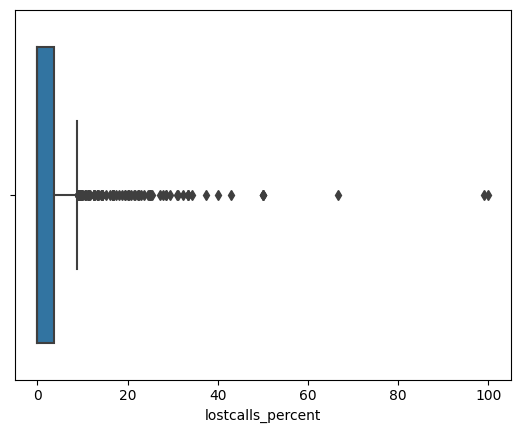

In [ ]:
#Creamos un grafico de caja para la distribución de los porcentajes por operador
sns.boxplot(x=missed_incoming_calls['lostcalls_percent'])
plt.show()

Como podemos observar en este grafico de caja, nuestro valores de media y la mayor parte de los datos estan cercanos al 0, esto se debe a que la mayor parte de los operadores tienen un pequeño porcentaje de llamadas perdidas, mientras se van volviendo mas raros los casos que tienen 100% de llamadas perdidas.

In [ ]:
missed_incoming_calls['lostcalls_percent'].describe(percentiles=[0.8,0.85,0.90,0.95,0.999])

count    755.000000
mean       3.766874
std        9.149525
min        0.000000
50%        0.000000
80%        5.880000
85%        8.330000
90%       12.500000
95%       20.498000
99.9%     99.306320
max      100.000000
Name: lostcalls_percent, dtype: float64

In [ ]:
#Excluimos todos los registros del operador 999 para el df missed_incoming_calls
filtered_missed_calls = missed_incoming_calls[missed_incoming_calls['operator_id'] != -1]
filtered_missed_calls.sort_values(by='lostcalls_percent',ascending=False).head()

missed_call,operator_id,False,True,lostcalls_percent
642,948756.0,0.0,1.0,100.00
186,904344.0,1.0,2.0,66.67
699,957922.0,1.0,1.0,50.00
288,913886.0,1.0,1.0,50.00
526,937898.0,1.0,1.0,50.00


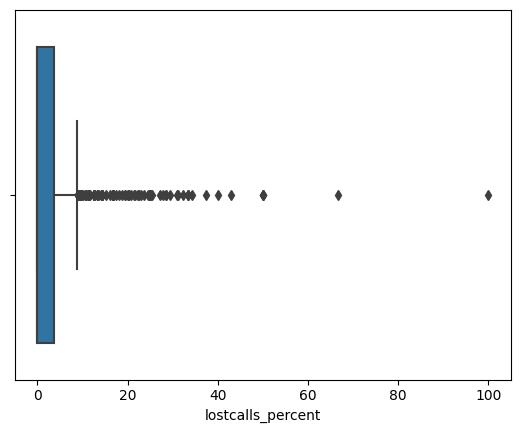

In [ ]:
#Volvemos a trazar una boxplot y el metodo describe()
sns.boxplot(x=filtered_missed_calls['lostcalls_percent'])
plt.show()

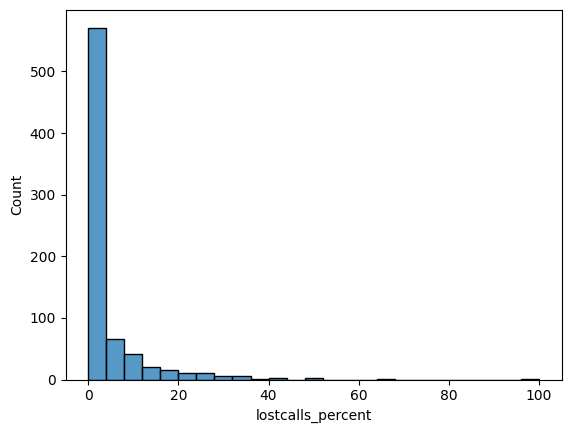

In [ ]:
#Creamos un histograma para visualizar la distribucion
plt.figure()
sns.histplot(data= filtered_missed_calls, x='lostcalls_percent',bins= 25)
plt.show()

Conforme al OEE que es un indicador para la eficiencia tienen una rubrica para clasificar en que porcentaje se encuentra dicho proceso, en nuestro caso ocuparemos esta rubrica y la tropicalizaremos para nuestro uso:
- una puntuación del 85% se considera `Eficiente`

- Una puntuación del 60% es bastante típica `regular`, pero indica que hay un margen considerable para la mejora.

- Una puntuación del 40% `deficiente`, Es una señal de que se pueden mejorar o tomar acciones correctivas con estos operadores.


Partiendo de esto vamos a clasificar los operadores conforme al resultado de `lostcalls_rating` con la rubrica mencionada.
Dado que obtener el 100% significa que el operador tiene el 100% de sus llamadas perdidas, tomaremos el complemento, es decir, el valor objetivo sera estar cerca al 0% de llamadas perdidas.
- lostcalls_percent < 15% es eficient,
- lostcalls_percent < 40% es regular,
- lostcalls_percent >40% inefficient.

In [ ]:
# Creamos una copia del dataframe para evitar errores al usar lambda
filtered_missed_calls = filtered_missed_calls.copy()
# Utilizando lambda evaluamos cada celda de lostcalls_percent conforme a la información de arriba
filtered_missed_calls['miss_call_rating'] = filtered_missed_calls['lostcalls_percent'].apply(
    lambda value: 'efficient' if value < 15 else 'regular' if value <= 40 else 'inefficient'
)
filtered_missed_calls

missed_call,operator_id,False,True,lostcalls_percent,miss_call_rating
1,879896.0,23.0,0.0,0.0,efficient
2,879898.0,63.0,0.0,0.0,efficient
3,880020.0,8.0,0.0,0.0,efficient
4,880022.0,8.0,0.0,0.0,efficient
5,880026.0,19.0,0.0,0.0,efficient
...,...,...,...,...,...
750,971102.0,5.0,0.0,0.0,efficient
751,971354.0,2.0,0.0,0.0,efficient
752,972412.0,1.0,0.0,0.0,efficient
753,972460.0,2.0,0.0,0.0,efficient


In [ ]:
#Comprobamos cuantos operadores existen en cada grupo.
filtered_missed_calls['miss_call_rating'].value_counts()

efficient      698
regular         50
inefficient      6
Name: miss_call_rating, dtype: int64

Con este método permite al supervisor en poner atención mucha atención a solo 6 personas y monitorear a 50 que se encuentran en regular, facilitando su tarea.
Aún con esta clasificación podemos observar que las personas inefficientes tienen pocas llamadas por lo que podemos determinar que los nuevos operadores requieren mejor capacitación.

In [ ]:
filtered_missed_calls[filtered_missed_calls['miss_call_rating']=='inefficient']

missed_call,operator_id,False,True,lostcalls_percent,miss_call_rating
186,904344.0,1.0,2.0,66.67,inefficient
288,913886.0,1.0,1.0,50.00,inefficient
330,919206.0,12.0,9.0,42.86,inefficient
526,937898.0,1.0,1.0,50.00,inefficient
642,948756.0,0.0,1.0,100.00,inefficient
699,957922.0,1.0,1.0,50.00,inefficient


#### Indicador para el tiempo de espera (hold_call_rating)

In [ ]:
#Agrupamos por operador e incluimos las columnas que nos sirven para el calculo de tiempo de espera.
hold_times = telecom_filtered.groupby('operator_id', as_index = False)[['calls_count', 'call_duration', 'total_call_duration']].sum()
hold_times.head()

,operator_id,calls_count,call_duration,total_call_duration
0,879896.0,1131,83261,97427
1,879898.0,7973,278876,391841
2,880020.0,54,2290,2624
3,880022.0,219,18304,22679
4,880026.0,2439,169674,193666


In [ ]:
#Calculamos el tiempo de espera.
hold_times['hold_calls'] = ((hold_times['total_call_duration'] - hold_times['call_duration']) / hold_times['calls_count']).round(3)
hold_times.head()

,operator_id,calls_count,call_duration,total_call_duration,hold_calls
0,879896.0,1131,83261,97427,12.525
1,879898.0,7973,278876,391841,14.168
2,880020.0,54,2290,2624,6.185
3,880022.0,219,18304,22679,19.977
4,880026.0,2439,169674,193666,9.837


In [ ]:
#Exploramos los datos con describe y colocamos percentiles para encontrar nuestros valores de
hold_times['hold_calls'].describe(percentiles= [0.15, 0.4, 0.5, 0.75, 0.8, 0.99] )

count    1092.000000
mean       16.456441
std         8.237670
min         0.000000
15%         9.000000
40%        14.103800
50%        15.827000
75%        20.006000
80%        21.121800
99%        45.757650
max        62.333000
Name: hold_calls, dtype: float64

In [ ]:
#excluimos al operador -1
hold_times_filtered = hold_times[hold_times['operator_id'] != -1]
hold_times_filtered

,operator_id,calls_count,call_duration,total_call_duration,hold_calls
0,879896.0,1131,83261,97427,12.525
1,879898.0,7973,278876,391841,14.168
2,880020.0,54,2290,2624,6.185
3,880022.0,219,18304,22679,19.977
4,880026.0,2439,169674,193666,9.837
...,...,...,...,...,...
1087,972410.0,77,3777,5275,19.455
1088,972412.0,61,3498,4548,17.213
1089,972460.0,70,2321,3122,11.443
1090,973120.0,3,5,25,6.667


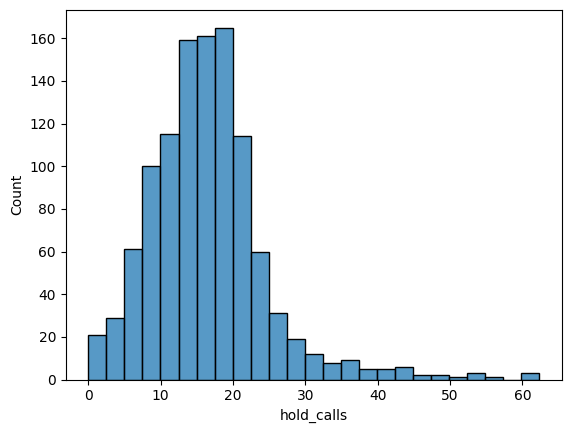

In [ ]:
#creamos un histograma
plt.figure()
sns.histplot(data= hold_times, x='hold_calls',bins= 25)
plt.show()

Conforme a la tabla presentada en la tesis de Orozco Cango, Sara Cristina, en la página 149 presenta una rubrica de clasificación que nos sirve para nuestra tarea.
El tiempo medio de respuesta TME en nuestro caso la columna `hold_calls` queda clásificado de la siguiente manera:
- TME > 10 seg Eficiente
- TME >= 20 seg Regular
- TME < 20 seg ineficiente

In [ ]:
#Utilizamos lambda para evaluar el tiempo promedio de duración
hold_times_filtered['hold_call_rating'] = hold_times_filtered['hold_calls'].apply(
    lambda value: 'efficient' if value < 10 else 'regular' if value <= 20 else 'inefficient'
)
hold_times_filtered

,operator_id,calls_count,call_duration,total_call_duration,hold_calls,hold_call_rating
0,879896.0,1131,83261,97427,12.525,regular
1,879898.0,7973,278876,391841,14.168,regular
2,880020.0,54,2290,2624,6.185,efficient
3,880022.0,219,18304,22679,19.977,regular
4,880026.0,2439,169674,193666,9.837,efficient
...,...,...,...,...,...,...
1087,972410.0,77,3777,5275,19.455,regular
1088,972412.0,61,3498,4548,17.213,regular
1089,972460.0,70,2321,3122,11.443,regular
1090,973120.0,3,5,25,6.667,efficient


In [ ]:
# Mostramos la cantidad de operadores que quedaron en cada grupo.
hold_times_filtered['hold_call_rating'].value_counts()

regular        607
inefficient    274
efficient      211
Name: hold_call_rating, dtype: int64

En el caso de este indicador tenemos mucho más operadores que tienen un desempeño que requieren atención, capacitación o revisar que factores externos pueden estar afectando el tiempo de espera de estas llamadas.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - El cálculo del indicador de tiempo de espera (hold_call_rating) es sólido, y el uso de percentiles para categorizar el tiempo medio de respuesta (TME) permite una evaluación más detallada del desempeño. La interpretación de los datos es clara, y la visualización mediante histogramas facilita la comprensión de la distribución. ¡Buen uso de criterios de eficiencia para evaluar a los operadores!

</div>

#### Indicador de llamadas salientes por operador (outcalls_rating)

In [ ]:
# Filtrar solo las llamadas salientes
outgoing_calls = telecom[telecom['direction'] == 'out']

# Contar el número de llamadas salientes por cada operador
outgoing_calls_count = outgoing_calls.groupby('operator_id').size().reset_index(name='outgoing_call_count')

# Mostrar el resultado
print(outgoing_calls_count)

     operator_id  outgoing_call_count
0           -1.0                  198
1       879896.0                  105
2       879898.0                  187
3       880020.0                   14
4       880022.0                   68
..           ...                  ...
878     972408.0                    3
879     972410.0                    4
880     972412.0                    4
881     972460.0                    7
882     973120.0                    2

[883 rows x 2 columns]


In [ ]:
# Filtramos los valores ausentes
outgoing_calls_filtered = outgoing_calls_count[outgoing_calls_count['operator_id']!=-1]
outgoing_calls_filtered

,operator_id,outgoing_call_count
1,879896.0,105
2,879898.0,187
3,880020.0,14
4,880022.0,68
5,880026.0,179
...,...,...
878,972408.0,3
879,972410.0,4
880,972412.0,4
881,972460.0,7


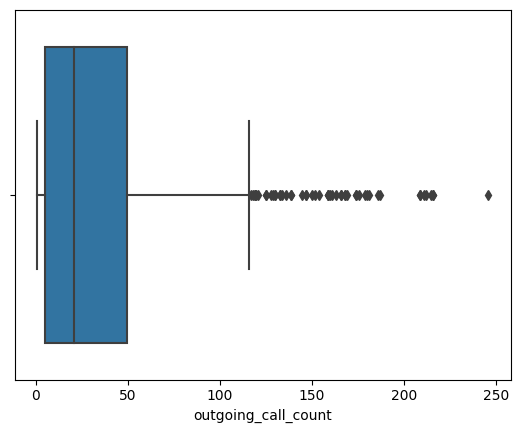

In [ ]:
sns.boxplot(x=outgoing_calls_filtered['outgoing_call_count'])
plt.show()

Como podemos observar la mayoria de los operadores han realizado menos de 100 llamadas y la media se encuentra en las 35 llamadas.

In [ ]:
outgoing_calls_filtered.describe(percentiles= [0.25,0.4,0.6,0.5,0.75,0.8,0.85,0.9,0.95,0.99])

,operator_id,outgoing_call_count
count,882.000000,882.000000
mean,925658.340136,35.960317
std,22862.558731,41.965280
min,879896.000000,1.000000
25%,906394.500000,5.000000
40%,919251.600000,12.400000
50%,924959.000000,21.000000
60%,937273.600000,31.000000
75%,943630.000000,49.750000
80%,945860.800000,59.800000


Con ayuda del boxplot y el metodo describe, excluimos los valores más extremos para poder establecer nuestra clasificación. Por lo que excluiremos los valores por encima del 95%


In [ ]:
outcalls_filtered = outgoing_calls_filtered[outgoing_calls_filtered['outgoing_call_count']<outgoing_calls_filtered['outgoing_call_count'].quantile(0.95)]
outcalls_filtered.describe()

,operator_id,outgoing_call_count
count,837.000000,837.000000
mean,927152.391876,28.998805
std,22364.035572,29.283121
min,879896.000000,1.000000
25%,907986.000000,5.000000
50%,929228.000000,19.000000
75%,944560.000000,45.000000
max,973120.000000,121.000000


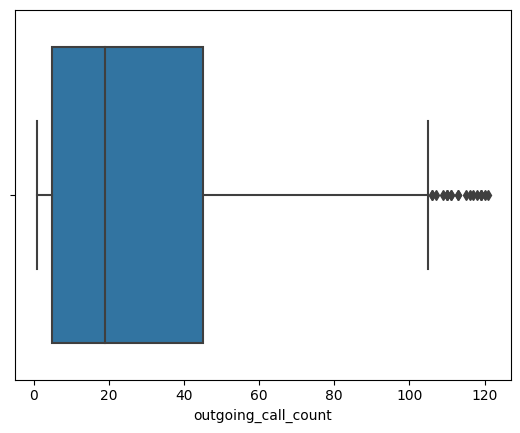

In [ ]:
sns.boxplot(x=outcalls_filtered['outgoing_call_count'])
plt.show()

Como podemos observar son mucho menos valores los que se encuentran fuera de nuestro boxplot por lo que podemos utilizar estos datos para generar una clásificación.

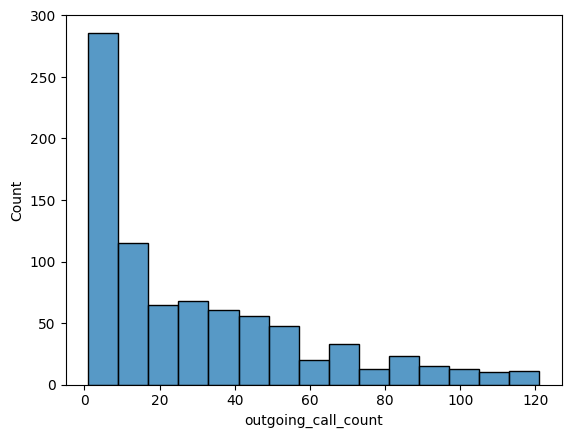

In [ ]:
sns.histplot(x=outcalls_filtered['outgoing_call_count'])
plt.show()

In [ ]:
outcalls_filtered.describe(percentiles = [0.6,0.85])

,operator_id,outgoing_call_count
count,837.000000,837.000000
mean,927152.391876,28.998805
std,22364.035572,29.283121
min,879896.000000,1.000000
50%,929228.000000,19.000000
60%,937734.400000,29.000000
85%,951377.600000,61.600000
max,973120.000000,121.000000


Ocupando la misma metrica de las llamadas entrantes establecemos nuestros valores de clasificiación.
- call_count < 85% - 62 `llamadas eficiente`
- call_count < 60% - 29 `regular`
- call_count menor sera `inefficient`

In [ ]:
#Creamos una copia para evitar mensajes de error
outcalls_filtered = outcalls_filtered.copy()
#Evaluamos outgoing_call_count con lambda
outcalls_filtered['outcall_rating'] = outcalls_filtered['outgoing_call_count'].apply(
    lambda value: 'efficient' if value > 62 else 'regular' if value >= 29 else 'inefficient'
)
outcalls_filtered

,operator_id,outgoing_call_count,outcall_rating
1,879896.0,105,efficient
3,880020.0,14,inefficient
4,880022.0,68,efficient
7,880240.0,14,inefficient
8,881278.0,8,inefficient
...,...,...,...
878,972408.0,3,inefficient
879,972410.0,4,inefficient
880,972412.0,4,inefficient
881,972460.0,7,inefficient


In [ ]:
outcalls_filtered['outcall_rating'].value_counts()

inefficient    500
regular        214
efficient      123
Name: outcall_rating, dtype: int64

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - El análisis de las llamadas salientes por operador (outcalls_rating) está bien estructurado. La exclusión de valores atípicos y el uso de la caja y el histograma para visualizar la distribución ofrecen una buena comprensión de la actividad de los operadores. Excelente aplicación de criterios para clasificar a los operadores en función de su número de llamadas salientes.

</div>


#### Evaluación de los operadores usando los tres indicadores.

In [ ]:
# Seleccionar y renombrar columnas en cada DataFrame
hold_times_filtered = hold_times_filtered[['operator_id', 'hold_call_rating']]
filtered_missed_calls = filtered_missed_calls[['operator_id', 'miss_call_rating']]
outcalls_filtered = outcalls_filtered[['operator_id', 'outcall_rating']]

# Unir los DataFrames en 'operator_id'
operator_rating = hold_times_filtered.merge(filtered_missed_calls, on='operator_id', how='outer') \
                            .merge(outcalls_filtered, on='operator_id', how='outer')

In [ ]:
operator_rating

,operator_id,hold_call_rating,miss_call_rating,outcall_rating
0,879896.0,regular,efficient,efficient
1,879898.0,regular,efficient,NaN
2,880020.0,efficient,efficient,inefficient
3,880022.0,regular,efficient,efficient
4,880026.0,efficient,efficient,NaN
...,...,...,...,...
1087,972410.0,regular,NaN,inefficient
1088,972412.0,regular,efficient,inefficient
1089,972460.0,regular,efficient,inefficient
1090,973120.0,efficient,NaN,inefficient


In [ ]:
operator_rating.isna().sum()

operator_id           0
hold_call_rating      0
miss_call_rating    338
outcall_rating      255
dtype: int64

In [ ]:
operator_rating[['miss_call_rating', 'hold_call_rating', 'outcall_rating']] = operator_rating[['miss_call_rating', 'hold_call_rating', 'outcall_rating']].fillna('regular')
operator_rating.isna().sum()

operator_id         0
hold_call_rating    0
miss_call_rating    0
outcall_rating      0
dtype: int64

In [ ]:
operator_rating

,operator_id,hold_call_rating,miss_call_rating,outcall_rating
0,879896.0,regular,efficient,efficient
1,879898.0,regular,efficient,regular
2,880020.0,efficient,efficient,inefficient
3,880022.0,regular,efficient,efficient
4,880026.0,efficient,efficient,regular
...,...,...,...,...
1087,972410.0,regular,regular,inefficient
1088,972412.0,regular,efficient,inefficient
1089,972460.0,regular,efficient,inefficient
1090,973120.0,efficient,regular,inefficient


Ahora trabajaremos con un metodo de ponderación:
- efficient = 3
- regular = 2
- inefficient = 1
Con estos valores generaremos una calificación para cada una de las columnas, y luego vamos a clasificar a los operadores de la siguiente manera con la suma de los puntos obtenidos:
- efficient > 8
- regular 5-7
- inefficient > 4

Como podemos observar por los datos ausentes y esto debido a los valores ausentes que se eliminarion o en su defecto dichos operadores no cuentan con evaluación en esos rubros. asi que para poder trabajar con la información rellenaremos los valores ausentes con regular.

In [ ]:
# Definir una función para asignar puntos según la calificación
def assign_points(rating):
    if rating == 'inefficient':
        return 1
    elif rating == 'regular':
        return 2
    elif rating == 'efficient':
        return 3
    else:
        return 0  # En caso de valores nulos o desconocidos

# Calcular el puntaje total para cada operador
operator_rating['total_score'] = (
    operator_rating['miss_call_rating'].apply(assign_points) +
    operator_rating['hold_call_rating'].apply(assign_points) +
    operator_rating['outcall_rating'].apply(assign_points)
)




# Aplicar la lógica de reemplazo de valores
operator_rating['total_rating'] = operator_rating['total_score'].apply(lambda x: 'efficient' if x >= 8 else ('regular' if 5 <= x <= 7 else ('inefficient' if x <= 4 else x)))

# Mostrar el resultado
operator_rating


,operator_id,hold_call_rating,miss_call_rating,outcall_rating,total_score,total_rating
0,879896.0,regular,efficient,efficient,8,efficient
1,879898.0,regular,efficient,regular,7,regular
2,880020.0,efficient,efficient,inefficient,7,regular
3,880022.0,regular,efficient,efficient,8,efficient
4,880026.0,efficient,efficient,regular,8,efficient
...,...,...,...,...,...,...
1087,972410.0,regular,regular,inefficient,5,regular
1088,972412.0,regular,efficient,inefficient,6,regular
1089,972460.0,regular,efficient,inefficient,6,regular
1090,973120.0,efficient,regular,inefficient,6,regular


In [ ]:
operator_rating['total_rating'].value_counts()

regular        909
efficient      127
inefficient     56
Name: total_rating, dtype: int64

En conclusión,
- contamos con 909 operadores que pueden trabajar sin ningún problema,
- contamos con 127 operadores que pueden mejorar pero se entan desempeñando dentro del promedio
- contamos con 56 operadores que requieren atención y deben ser supervisados para alcanzar al promedio.

Con este método de evaluación logramos gestionar y visualizar que operadores son los que requieren principalmente atención, lo cual significa que es mucho mas sencillo enfocarse en solo 56 operadores que en todos. Así también, administrando mejor nuestros recursos e identificar las áreas de mejora de los operadores.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - La evaluación combinada de los operadores utilizando los tres indicadores es completa y permite una visión integral del rendimiento de los operadores. La metodología de asignación de puntos y categorización final (efficient, regular, inefficient) facilita la priorización de recursos para la supervisión. Muy buen enfoque para clasificar a los operadores según su desempeño global.

</div>


#### Probar la hipotesis #1: Existe una relación entre la cantidad de llamadas perdidas y los diferentes planes. Utilizando chi^2

- Hipótesis nula (H₀): No existe relación entre la cantidad de llamadas perdidas y los diferentes planes.
- Hipótesis alternativa (H₁): Existe una relación entre la cantidad de llamadas perdidas y los diferentes planes.

Vamos a evaluar si un plan puede llegar a tener mayor cantidad de llamadas perdidas, para esto utilizaremos chi^2 para ver la diferencia entre varios grupos.

In [ ]:
#Filtramos para solo tener las columnas que necesitamos para la prueba.
chi = telecom_filtered[['tariff_plan','missed_call']]


In [ ]:
tabla_contingencia = pd.crosstab(chi['tariff_plan'], chi['missed_call'])
# Realizar la prueba Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
# Evaluación
print("Estadístico Chi-cuadrado:", chi2)
print("p-valor:", p)

# Interpretación
if p < 0.05:
    print("Existe una relación significativa entre la cantidad de llamadas perdidas y los diferentes planes.")
else:
    print("No existe una relación significativa entre la cantidad de llamadas perdidas y los diferentes planes.")

Estadístico Chi-cuadrado: 25.303085563939597
p-valor: 3.20261535998902e-06
Existe una relación significativa entre la cantidad de llamadas perdidas y los diferentes planes.


Como podemos observar tenemos una relación entre los diferentes planes y las llamadas perdidas.
Se recomienda: Analizar las diferentes causas que puede estar generando esta alta relación, por una parte tenemos a los operadores y por otro lado tenemos otros factores como las

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - El análisis de la hipótesis #1 muestra una ejecución precisa de la prueba Chi-cuadrado, y los resultados indican una relación significativa entre los planes tarifarios y las llamadas perdidas. La recomendación de investigar causas adicionales proporciona un buen enfoque para profundizar en los resultados obtenidos.

</div>

#### Probar la hipotesis #2:  Los operadores eficientes realizan más llamadas salientes. Utilizando prueba t de dos muestras. comparando los promedios.
- Hipótesis nula (H₀): No existe una diferencia significativa en el número de llamadas salientes realizadas por operadores eficientes y no eficientes.
- Hipótesis alternativa (H₁): Los operadores eficientes realizan significativamente más llamadas salientes que los no eficientes.

In [ ]:
# Unimos las tablas mediante merge on 'operator_id' left para agregar la calificación al operador.
telecom_rating = telecom.merge(operator_rating, on= 'operator_id', how= 'left')
#Excluimos el operador -1
telecom_rating = telecom_rating[telecom_rating['operator_id']!= -1]
telecom_rating.head(2)

,user_id,date,direction,internal,operator_id,missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,hold_call_rating,miss_call_rating,outcall_rating,total_score,total_rating
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,B,2019-08-01,regular,efficient,efficient,8.0,efficient
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,B,2019-08-01,efficient,efficient,inefficient,7.0,regular


In [ ]:

# Filtrar operadores eficientes y no eficientes para llamadas salientes (direction = 'outgoing')
efficient_calls = telecom_rating[(telecom_rating['total_rating'] == 'efficient') &
                                 (telecom_rating['direction'] == 'out')]['calls_count']
inefficient_calls = telecom_rating[(telecom_rating['total_rating'] == 'inefficient') &
                                   (telecom_rating['direction'] == 'out')]['calls_count']

# Realizar la prueba t de dos muestras
t_stat, p_value = ttest_ind(efficient_calls, inefficient_calls, equal_var=False)

# Mostrar resultados
t_stat, p_value

(-24.42266099368988, 2.1903012862193604e-94)

T_stat de -24.42266099368988 indica que la hipotesis nula se rechaza y existe una diferencia entre ambos grupos, lo que se traduce que con operadores eficientes tienen mayor número de llamadas que los no eficientes.
p-value: se encuentra cerca de 0, esto comprueba que podemos rechazar la hipotesis nula con mucha confianza.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - El análisis de la hipótesis #2 utilizando la prueba t de dos muestras es un excelente enfoque para validar la relación entre la eficiencia del operador y el número de llamadas salientes. La interpretación de los resultados de t-stat y p-value permite una conclusión confiable sobre el desempeño de los operadores eficientes en comparación con los ineficientes. ¡Buen trabajo!

</div>

## `Crear pipeline para dashboard`

- Traza un histograma que muestre la calificación de los operadores
- Traza un gráfico circular que muestre la participación de las llamadas internas y externas
- Agrega un filtro por tipo de llamada (interna o externa)
- Agrega un filtro por plan

### Link de presentación a Dashboard en Tableau
Presentation: <https://public.tableau.com/views/Dashboard_telecom_17308317422890/Dashboard1?:language=es-ES&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link>

## Conclusiones

Logramos crear indicadores que nos sirvan para evaluar la eficiencia de los operadores de una empresa.
1) llamadas perdidas
2) tiempo de espera
3) llamadas salientes


Y como logramos comprobar en nuestras hipotesis, tenemos una relación entre los diferentes planes y las llamadas perdidas, quedaria explorar la distribución de los operadores novatos para equilibrar los planes y mejorar la eficiencia en los tres grupos.
En el caso, de la segunda hipotesis, nos sirvio para corroborar que nuestro indicador de llamadas salientes realmente tiene algun impacto. Donde comprobamos que existe relación entre los operadores eficacez y el número de llamadas.
Finalmente, la clasificación que se realizo nos sirvio de ayuda para reducir el grupo de operadores a los cuales hay que prestar atención y capacitarlos.

Otras recomendaciones serian:
- Tenemos un gran número de registros sin número de usuario, sin embargo, no contamos con información suficiente para relacionarlos. Por lo que se recomienda verificar que los datos esten correctamente capturados.
- Aumentar la capacitación, si bien nuestro grupo de operadores ineficientes es de 56 operadores, la población de operadores regulares supera por mucho a la de eficientes. por lo que requieren atención.
- Establecer los objetivos conforme a la medias obtenidas con estos indicadores para que los operadores intenten llegar a estos números y así puedan mejorar.



# Fuentes

https://repositorioacademico.upc.edu.pe/bitstream/handle/10757/582088/Orozco_CS.pdf
    - Se utilizo la información de esta tesis para obtener el método de evaluación para el tiempo de espera.

https://www.redalyc.org/journal/339/33962773006/html/
    - Se utilizo para obtener la tabla de comparación para el OEE y poder tropicalizar un sistema de evaluación.
    

https://www.scielo.cl/scielo.php?script=sci_arttext&pid=S0370-41062007000400010
    -Se utilizo para entender el funcionamiento y eleccion de chi^2 para nuestra prueba de hipotesis.

https://www.redalyc.org/pdf/214/21400107.pdf
    - Se utilizo para consultar algunos terminos como eficiencia y eficacia.

https://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S0188-21982015000100009
    - Se utilizo para entender el uso de la T-Student

# Comentario General del Revisor
<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

La implementación del cálculo de la tasa de llamadas perdidas por operador es un paso crucial y efectivo para identificar operadores que necesitan supervisión adicional. Tu enfoque de utilizar un porcentaje de llamadas perdidas en lugar de un conteo absoluto es acertado, ya que permite una comparación justa entre operadores con diferentes niveles de experiencia y cargas de trabajo.

#### Puntos Destacados:
- **Uso de Pivot Table:** La transformación de los datos mediante una tabla pivot para contabilizar llamadas perdidas y atendidas es clara y facilita el análisis.
- **Clasificación en Función de Tasa de Pérdida:** La clasificación de operadores en "ineficiente," "regular," y "eficiente" según la tasa de llamadas perdidas es una buena práctica, alineada con estándares de eficiencia en el contexto de CallMeMaybe.
- **Gráficos de Distribución:** Los gráficos de caja e histogramas aportan una excelente visualización de la distribución y ayudan a observar los valores atípicos de manera rápida.

#### Sugerencias para Mejorar:
- **Manejo de Valores Faltantes:** La imputación de valores faltantes en `missed_call` con ceros facilita el análisis, pero sería ideal considerar una revisión adicional sobre cómo esos datos faltantes pueden influir en la clasificación final.
- **Justificación de Umbrales:** Aunque se mencionó que los umbrales de 15% y 40% son aproximaciones de OEE, una breve justificación sobre cómo estos valores reflejan la operativa de CallMeMaybe enriquecería el análisis.

¡Sigue así! Esta sección proporciona un buen punto de partida para evaluar la eficacia operativa y permite un enfoque orientado a la mejora continua de los operadores.
</div>
